In [1]:
# import necessary modules
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
# Libraries importation
import os # operating system interfaces
from os.path import join
from glob import glob
import numpy as np # scientific computing
import pandas as pd # data analysis
import tensorflow as tf
import matplotlib.pyplot as plt # plots
import PIL # image files manipulation
import random

# callback to reduce learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

# opencv to handle images (https://opencv.org/releases/)
import cv2 as cv

# print metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, \
    confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.8.2


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


In [4]:
# set variable for file_path and data_dir
file_path ='/content/drive/MyDrive/covid-data_pr/Covid19-dataset/data/train/'
data_dir = pathlib.Path(file_path)

#IDG

In [6]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
batch_size= 8
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

In [8]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/covid-data_pr/Covid19-dataset/data/train", 
                                                           seed=seed, 
                                                           batch_size=batch_size)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

Found 251 images belonging to 3 classes.


In [9]:
print(image_generator.class_indices)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [10]:
class_labels = image_generator.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

{0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'}


#TRAINING

In [11]:
# Split train and validation data
SEED = 1234
BATCH_SIZE = 16
IMG_SIZE = (160,160)

train_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         validation_split = 0.2,
                                                         subset = 'training',
                                                         seed = SEED,
                                                         image_size = IMG_SIZE,
                                                         batch_size = BATCH_SIZE,
                                                         shuffle = True
                                                         )

val_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = SEED,
                                                       image_size = IMG_SIZE,
                                                       batch_size = BATCH_SIZE,
                                                       shuffle = True
                                                       )

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.


In [12]:
print(f"total train data per batch: {len(train_data)}")
print(f"total validation data per batch: {len(val_data)}")

total train data per batch: 13
total validation data per batch: 4


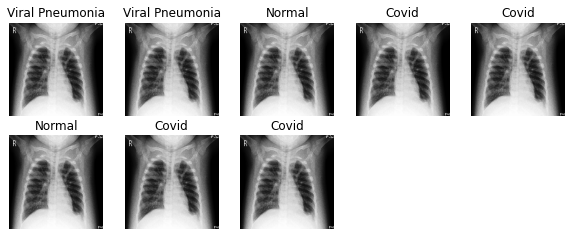

In [13]:
# set variable for class_names
class_names = train_data.class_names

# plot the train_data image
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(batch_size):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [14]:
# perform split of validation data into test data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches//2)
val_data = val_data.skip(val_batches//2)

In [15]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_data)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_data)}")

Number of validation batches: 2
Number of test batches: 2


In [16]:
print(f"total train data: {len(train_data)}")
print(f"total validation data: {len(val_data)}")
print(f"total test data: {len(test_data)}")

total train data: 13
total validation data: 2
total test data: 2


In [17]:
# create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size = AUTOTUNE)
val_data = val_data.prefetch(buffer_size = AUTOTUNE)
test_data = test_data.prefetch(buffer_size = AUTOTUNE)

In [18]:
# preprocess image input to rescale the image to fit into the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet'
                                         )

58900480/58889256 [==============================] - 1s 0us/step


In [20]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [21]:
# Freeze the entire base_model
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [22]:
# set variable for classfier layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# set variable for output layer
nClass = len(class_names)
prediction_layer = tf.keras.layers.Dense(nClass, activation = 'softmax')

In [23]:
# re-construct the model
inputs = tf.keras.Input(shape = (160,160,3))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [25]:
# check the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

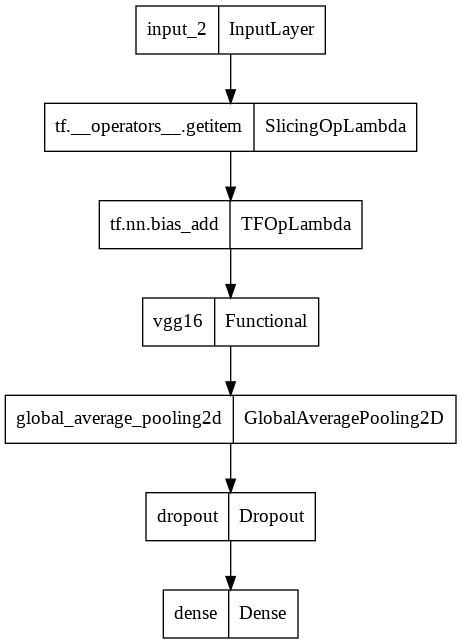

In [26]:
tf.keras.utils.plot_model(model)

In [27]:
loss0, accuracy0 = model.evaluate(val_data)

print("---------------------------------------------Before Training---------------------------------------------")
print("loss", loss0)
print("accuracy", accuracy0)

2/2 [==============================] - 26s 658ms/step - loss: 8.3217 - accuracy: 0.2778
---------------------------------------------Before Training---------------------------------------------
loss 8.321685791015625
accuracy 0.2777777910232544


In [28]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from gc import callbacks
import datetime, os
#logdir = os.path.join("/content/drive/MyDrive/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es_callback = callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 2)

In [29]:
# start train the model
initial_epochs= 10 
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = val_data,
                    callbacks = [es_callback])

Epoch 1/10
13/13 [==============================] - 19s 1s/step - loss: 6.0808 - accuracy: 0.4677 - val_loss: 4.6471 - val_accuracy: 0.4444
Epoch 2/10
13/13 [==============================] - 4s 160ms/step - loss: 5.0480 - accuracy: 0.4129 - val_loss: 4.1803 - val_accuracy: 0.3333
Epoch 3/10
13/13 [==============================] - 4s 154ms/step - loss: 4.4401 - accuracy: 0.3980 - val_loss: 4.0493 - val_accuracy: 0.3333
Epoch 4/10
13/13 [==============================] - 4s 158ms/step - loss: 3.8131 - accuracy: 0.4478 - val_loss: 3.1734 - val_accuracy: 0.4444
Epoch 5/10
13/13 [==============================] - 4s 159ms/step - loss: 3.6099 - accuracy: 0.4428 - val_loss: 3.5845 - val_accuracy: 0.4444
Epoch 6/10
13/13 [==============================] - 4s 160ms/step - loss: 3.5872 - accuracy: 0.4378 - val_loss: 3.0395 - val_accuracy: 0.1667
Epoch 7/10
13/13 [==============================] - 4s 195ms/step - loss: 3.1209 - accuracy: 0.4478 - val_loss: 2.0718 - val_accuracy: 0.3889
Epoch 8/

In [30]:
#tf.keras.backend.clear_session()

In [31]:
# View training accuracy and loss graph via tensorboard
#%tensorboard --logdir new_logs/

In [32]:
# Perform FINE TUNING of the trained model
# In the first feature extraction training, the model was only trained a few layers on top of VGG19 base_model. The weights of the pretrained network were not updated during training
# Fine_tuning is method to increase performance even further or "fine-tunes" the weights of the top layer of the VGG19 model alongside the classifier added
# We need to unfreeze the top layers- pf the base model
base_model.trainable = True

In [33]:
# let's take a look at the model layers
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [34]:
# So, we are going to fine-tune 10 layers ahead
fine_tune_at = 10

# Freeze all the layer before "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [35]:
# compile the model again
# As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy'])

In [36]:
# lets check the model again
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [37]:
# Now, we resume the model trianing from the last epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

# train the model again
histroy_fine_tune = model.fit(train_data,
                              epochs = total_epochs,
                              initial_epoch = history.epoch[-1],
                              validation_data = val_data,
                              callbacks = [es_callback])

Epoch 10/60
13/13 [==============================] - 7s 198ms/step - loss: 1.5984 - accuracy: 0.6965 - val_loss: 0.3411 - val_accuracy: 0.8889
Epoch 11/60
13/13 [==============================] - 4s 178ms/step - loss: 0.3636 - accuracy: 0.8657 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 12/60
13/13 [==============================] - 4s 182ms/step - loss: 0.1749 - accuracy: 0.9403 - val_loss: 0.2349 - val_accuracy: 0.9444
Epoch 13/60
13/13 [==============================] - 4s 175ms/step - loss: 0.0907 - accuracy: 0.9701 - val_loss: 0.1515 - val_accuracy: 0.9444
Epoch 14/60
13/13 [==============================] - 4s 181ms/step - loss: 0.0785 - accuracy: 0.9701 - val_loss: 0.1928 - val_accuracy: 0.9444
Epoch 15/60
13/13 [==============================] - 4s 181ms/step - loss: 0.0145 - accuracy: 0.9950 - val_loss: 0.0801 - val_accuracy: 0.9444
Epoch 16/60
13/13 [==============================] - 4s 175ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.2302 - val_accuracy: 0.9444

In [38]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)

-----------------------------------After Fine-tuning model..........................................
2/2 [==============================] - 1s 44ms/step - loss: 0.1528 - accuracy: 0.9688


[0.1528482437133789, 0.96875]

In [39]:
# Use test data to make prediction
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)

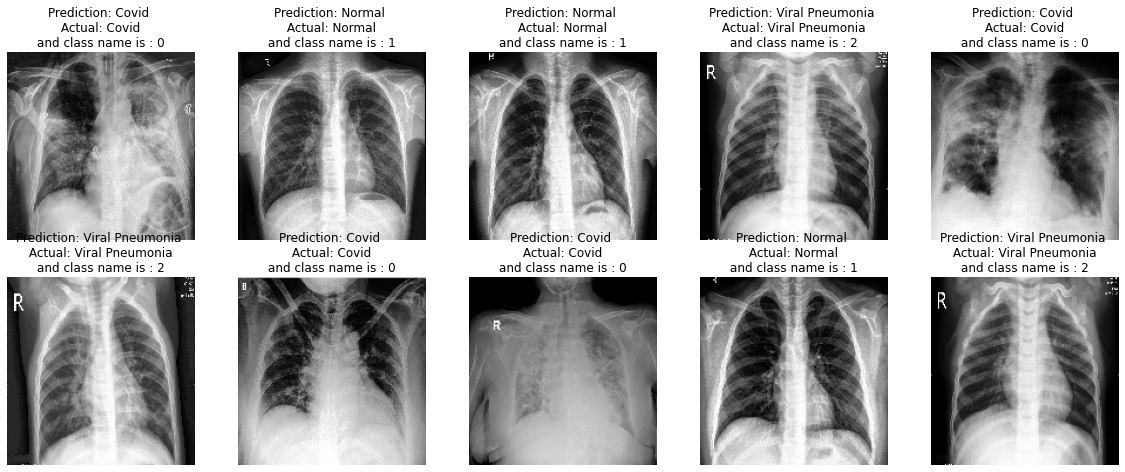

In [40]:
# plot the prediction vs actual label
plt.figure(figsize = (20,20))
for i in range(10):
  axs = plt.subplot(5,5,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  current_prediction = class_names[class_predictions[i]]
  current_label = class_names[label_batch[i]]
  plt.title(f"Prediction: {current_prediction} \n Actual: {current_label} \n and class name is : {label_batch[i]} ")
  plt.axis('off')

In [41]:
%cd /content/drive/MyDrive/covid-data_pr

/content/drive/MyDrive/covid-data_pr


In [42]:
model.save('covid_prediction.h5')

In [43]:
############confusion matrix from tayssir :
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
subfolders = [ f.path for f in os.scandir(file_path) if f.is_dir() ]
def get_index_of_biggest(arr):
  max_value = max(list(arr))
  max_index = list(arr).index(max_value)
  return max_index
def simple_predict():
  classes = ["Covid","Normal","Viral Pneumonia"]
  true_vals = []
  pred_vals = []
  for dir in subfolders:
    _class_ = dir.split("/")
    _class_ = _class_[len(_class_)-1]
    i,_file_ = 0,list(os.scandir(dir))
    while i < len(_file_):
      file_to_use = str(_file_[i]).replace("<DirEntry '",'').replace("'>","")
      img = image.load_img(dir+"/"+str(file_to_use), target_size=(160, 160))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])
      prediction = model.predict(images, batch_size=10)
      true_vals.append(_class_)
      pred_vals.append(classes[get_index_of_biggest(prediction[0])])
      if i < 66:
        i = i+1
      else:
        break
  return true_vals,pred_vals
y_t,y_p = simple_predict()
print(confusion_matrix(y_t,y_p))

[[67  0  0]
 [ 0 67  0]
 [ 0  1 66]]
